# Volatility Trading with VIX Forecasting

Sean Lin, Thomas McDonnell, Benjamin Panovich, Madison Rusch

In [1]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import data_collection 
import model_building
import trading_strategy

import warnings 
warnings.filterwarnings('ignore')

In [2]:
KEY = os.getenv('QUANDL_KEY')

## 1. Introduction

> Introduction

***

## 2. Building the Model

> Overview

I'm setting the parameters for the Data Collection class here

In [3]:
START_DATE, END_DATE = '2014-01-01', '2021-12-31'
YEARS = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']
MONTH_CODES = ['H','M','U','Z']
DataCollection = data_collection.DataCollection(KEY,START_DATE,END_DATE,YEARS,MONTH_CODES) # Class for data collection 

Importing all the data (I already processed some of it so we don't need to redo it here, should say where we got it). Also using the convert_calendar() function to convert the economic calendar to number of days to next event, and then shifting all the needed data

also now using MSCI EAFE instead of the SSEC index like in the paper. someone should verify when this data actually closes (to be sure we can use it in same style). MSCI EAFE is developed markets ex us

In [4]:
vix_data = pd.read_csv('./data/vix_data.csv',index_col=0,parse_dates=True) # Downloading processed data 
raw_calendar_data = pd.read_csv('./data/calendar_raw.csv',index_col=0,parse_dates=True)
eafe_data = pd.read_csv('./data/eafe_data.csv',index_col=0,parse_dates=True)
spy_data = DataCollection.fetch_quandl_table('QUOTEMEDIA/PRICES','SPY')

calendar_data = DataCollection.convert_calendar(raw_calendar_data,vix_data) # Converting raw calendar data to processed data 
predictors = pd.concat([vix_data,eafe_data,spy_data,calendar_data],axis=1)

predictors['VIX Returns'] = predictors['VIX'].pct_change().shift(-1) # Shifting data
predictors['SPY Returns'] = predictors['close'].pct_change() 
predictors['EAFE Returns'] = predictors['EAFE'].pct_change().shift(-1)
predictors['Days until Event'] = predictors['Days until Event'].shift(-1)
predictors['Volume Change'] = predictors['volume'].pct_change()
predictors = predictors[['VIX Returns','SPY Returns','EAFE Returns','Days until Event','Volume Change']].dropna()

made a model buildign class to build the model

In [5]:
Model = model_building.Model(predictors,126)
Model.train_model()

100%|██████████| 1887/1887 [02:25<00:00, 12.94it/s]


> We should check to make sure our parameters are actually significant

In [6]:
pvalues = Model.pvalues

Someone convert these to gg plots to a new grid. these are the p-values (notable thresholds are 0.05 and 0.01, lower is better)

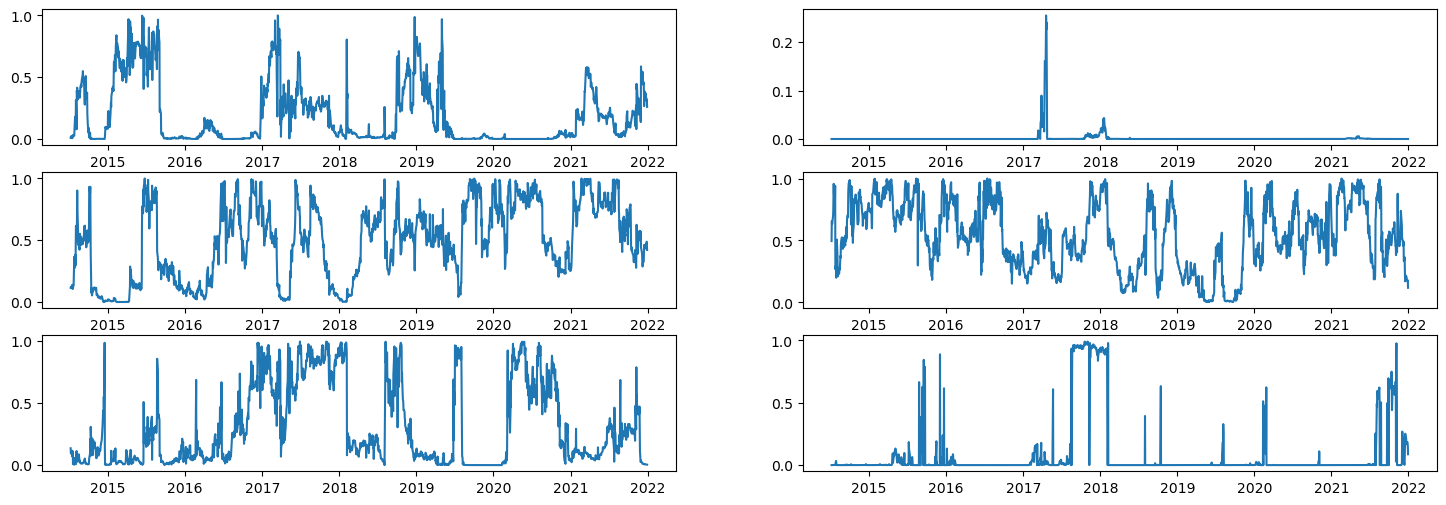

In [7]:
fig, ax = plt.subplots(3,2,figsize=(18,6))
ax[0,0].plot(pvalues['SPY Returns'])
ax[0,1].plot(pvalues['EAFE Returns'])
ax[1,0].plot(pvalues['Days until Event'])
ax[1,1].plot(pvalues['Volume Change'])
ax[2,0].plot(pvalues['AR'])
ax[2,1].plot(pvalues['MA'])

> We see that SPY Returns and EAFE returns are the most signifciant. Days until event appears to be sometimes significant. To make the model simpler, we will get rid of SPY Volume since it does not appear to be significant. This is in agreement with the paper (though they didn't try economic calendar).

In [5]:
predictors_new = predictors[['VIX Returns','SPY Returns','EAFE Returns','Days until Event']]
Model_new = model_building.Model(predictors_new,126)
Model_new.train_model()

100%|██████████| 1887/1887 [02:07<00:00, 14.79it/s]


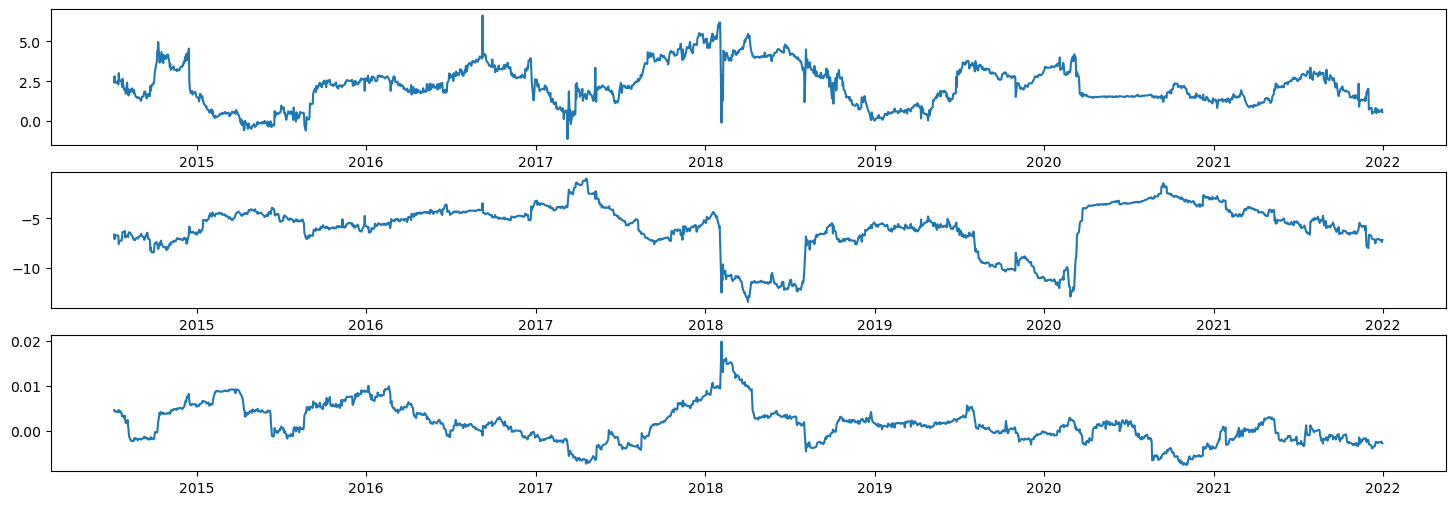

In [6]:
betas = Model_new.betas
fig, ax = plt.subplots(3,1,figsize=(18,6))
ax[0].plot(betas['SPY Returns'])
ax[1].plot(betas['EAFE Returns'])
ax[2].plot(betas['Days until Event'])

> The betas look like the results from the paper. We see that EAFE has negative betas while SPY has positive betas. We see the magnitude is also lower for the economic calendar data.

In [7]:
Model_new.performance_metrics(0.8,0.2)
metrics = Model_new.metrics
metrics

,MSE,DA,Up Acc,Down Acc,Prediction Num
Metrics,0.007176,0.625861,0.729469,0.823077,337


In [8]:
Model_new.predicted_results.dropna()

,predictions,actual,upper threshold,lower threshold
2015-01-02,0.157470,0.119730,0.061123,-0.049224
2015-01-05,0.039045,0.060241,0.062260,-0.049224
2015-01-06,0.005390,-0.085701,0.062260,-0.049224
2015-01-07,-0.094589,-0.119109,0.061123,-0.050161
2015-01-08,0.033210,0.031746,0.061123,-0.051093
...,...,...,...,...
2021-12-23,-0.018936,-0.015590,0.065695,-0.065470
2021-12-27,-0.037407,-0.007919,0.065695,-0.065470
2021-12-28,-0.020735,-0.033637,0.065695,-0.065470
2021-12-29,0.023238,0.022419,0.065695,-0.065470


In [5]:
predicted_results = pd.read_csv('model_temp.csv',index_col=0,parse_dates=True) # Temporary file so i don't have to re-run the ARIMA 

In [6]:
predicted_results = predicted_results.dropna()
predicted_results

,predictions,actual,upper threshold,lower threshold
2015-01-02,0.157470,0.119730,0.061123,-0.049224
2015-01-05,0.039045,0.060241,0.062260,-0.049224
2015-01-06,0.005390,-0.085701,0.062260,-0.049224
2015-01-07,-0.094589,-0.119109,0.061123,-0.050161
2015-01-08,0.033210,0.031746,0.061123,-0.051093
...,...,...,...,...
2021-12-23,-0.018936,-0.015590,0.065695,-0.065470
2021-12-27,-0.037407,-0.007919,0.065695,-0.065470
2021-12-28,-0.020735,-0.033637,0.065695,-0.065470
2021-12-29,0.023238,0.022419,0.065695,-0.065470


still need to add more analysis in this section, but this is the general gist of it. statistical analysis here is best

***

In [7]:
TradingStrategy = trading_strategy.TradingStrategy(predicted_results.dropna(),2)

In [8]:
TradingStrategy.create_signals()